In [ ]:
from ce3_compare import set_name, compare, write_submission_txt, grade, set_idm
from feature_model import FeatureModel
import numpy as np

In [2]:
set_name("changhun", "Kim")
set_idm("no12neni")

# Computer exercise 3 (Global post-hoc methods)

- Partial dependence plots (PDP)
- Individual conditional expectation (ICE) <- *local*
- M-Plot
- Accumulated local effects (ALE)
- Permutation feature importance

<img src="pdp_ice_mplot_ale.png" width="1200"/>

## Partial dependence plots (PDP)

In [5]:
bike_path = "datasets/bike/rented_bikes_day_pre.csv"
bike_data = FeatureModel(bike_path)
bike_data.df = bike_data.df.drop(labels=["casual", "registered"], axis=1)
bike_data.add_target("cnt")
bike_data.add_all_features_but_target()

FeatureModel(->Not fully specified yet!)
FeatureModel(cnt ~ -1 + season + yr + mnth + holiday + weekday + workingday + weathersit + temp + hum + windspeed + days_since_01_01_2011 )


In [6]:
X,y = bike_data.return_Xy(train_test_split=False)

In [7]:
from sklearn.inspection import PartialDependenceDisplay

def pdp_plot(M, X_train, y_train, X_val=None, kind="average", features=["temp","hum","windspeed"]):
    if X_val is None:
        X_val = X_train

    try:
        m = M()
    except:
        m = M

    m.fit(X_train, y_train)
    print("R2-score: ", m.score(X_train, y_train))

    pdp = PartialDependenceDisplay.from_estimator(
        m,
        X_val,
        features,
        kind=kind, grid_resolution=100, percentiles=(0,1),
    )

    for ax in pdp.axes_[0,:]:
        ax.grid(True)
        ax.set_ylim(0,6000)


### PDP for Linear Regression

R2-score:  0.8003086666446174


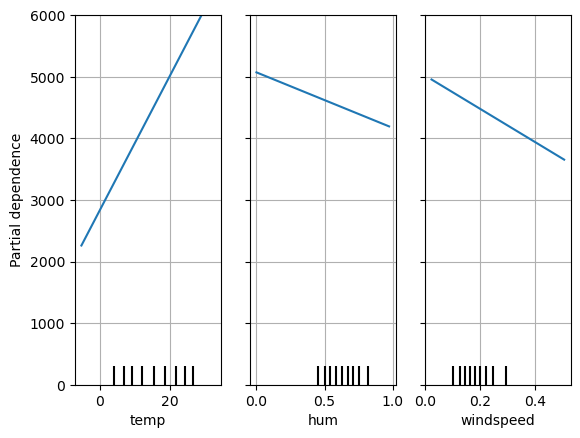

In [8]:
from sklearn.linear_model import LinearRegression

pdp_plot(LinearRegression, X, y)

Q: What is the meaning of the y-axis in the PDP plot?

Q: What is the meaning of the y-axis for classification?

Q: Does it make sense to create a PDP plot for a LinearRegression?

Q: Does it make sense to create a PDP plot for any inherently explainable model?

### PDP for RandomForestRegressor

/var/folders/34/q4vcf0710b9cm75lplc7sx2w0000gn/T/ipykernel_15700/4158344143.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  m.fit(X_train, y_train)


R2-score:  0.9848040825583197


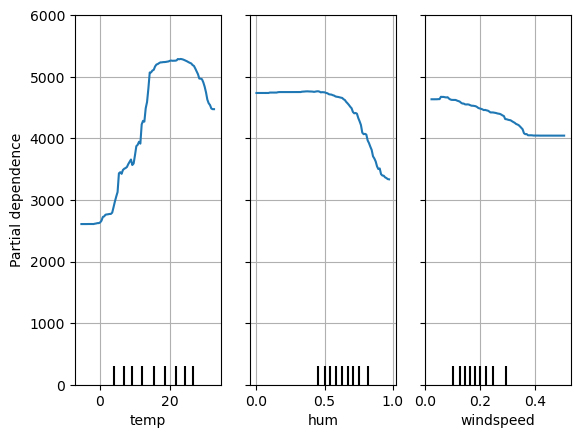

In [9]:
from sklearn.ensemble import RandomForestRegressor

pdp_plot(RandomForestRegressor, X, y)

### PDP for AdaBoost

/Users/gimchangheon/opt/anaconda3/envs/xML/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


R2-score:  0.8516520180312396


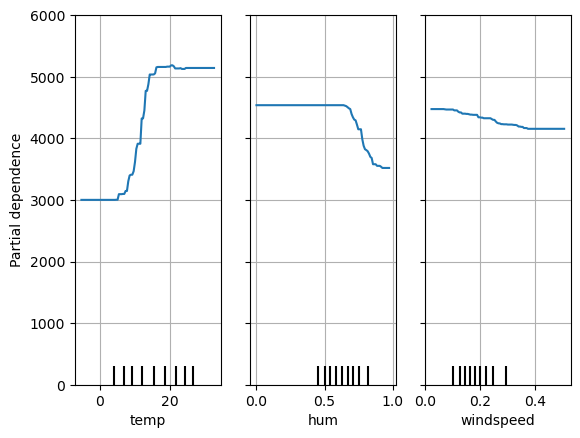

In [10]:
from sklearn.ensemble import AdaBoostRegressor

pdp_plot(AdaBoostRegressor, X, y)

Q: Does it make sense to use validation data for the averaging?

Q: If you want to explain your model's behaviour, would you use all data / only training data / only validation data?

In [11]:
X_train, y_train, X_val, y_val = bike_data.return_Xy(train_test_split=True)

/var/folders/34/q4vcf0710b9cm75lplc7sx2w0000gn/T/ipykernel_15700/4158344143.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  m.fit(X_train, y_train)


R2-score:  0.9821751701114279


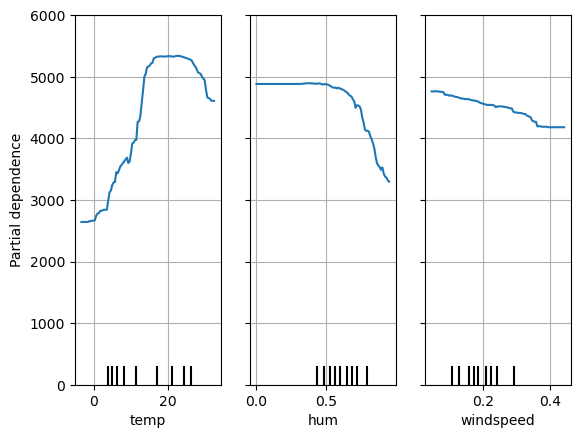

In [12]:
pdp_plot(RandomForestRegressor, X_train, y_train, X_val)

In [13]:
print( X_train['temp'].min() , X_train['temp'].max())
print( X_val['temp'].min() , X_val['temp'].max())

-5.2208712 31.910849
-3.4226089 32.498349


### Exercise 3.1

Use a `RandomForestRegressor` with `random_state`=1 to predict the number of rented bikes. What is the $\Delta y$ in the last/directly above PDP-plot for the `temp` feature between $20^\circ$ and $0^\circ$? Write a function that returns that exact value.

In [15]:
def get_pd(model, X_val, feature, value):
    X_val_new = X_val.copy()
    X_val_new[feature] = value
    prediction = model.predict(X_val_new)
    partial_dependence = np.average(prediction)
    return partial_dependence

def ex_3_1() -> float:
    model = RandomForestRegressor(random_state=1)
    model.fit(X_train, y_train)
    
    pd_20 = get_pd(model, X_val, 'temp', 20)
    pd_10 = get_pd(model, X_val, 'temp', 0)
    return pd_20 - pd_10

compare("ex_3_1", ex_3_1)


/var/folders/34/q4vcf0710b9cm75lplc7sx2w0000gn/T/ipykernel_15700/3655831240.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


Great work!


### Exercise 3.2

In the last/directly above PDP-plot for the `windspeed` feature on the x-axis, on which windspeed value is exactly the 5th vertical line? Write a function that returns that exact value.

In [16]:
def line_value(i, min_wind, max_wind, n):
    return min_wind + (i - 1) * (max_wind - min_wind) / (n - 1)


In [17]:
line_value(5, X_val['windspeed'].min(), X_val['windspeed'].max(), 10)

0.22216688888888886

In [18]:
def ex_3_2() -> float:
    return X_val['windspeed'].quantile(q=0.5)


In [19]:
compare("ex_3_2", ex_3_2)

Great work!


### PDP for classification

In [20]:
cancer_path = "datasets/cervical_cancer/risk_factors_cervical_cancer_pre.csv"
cancer_data = FeatureModel(cancer_path)
cancer_data.add_target("Biopsy")
cancer_data.add_all_features_but_target()
X_train, y_train, X_val, y_val = cancer_data.return_Xy(train_test_split=True)

FeatureModel(->Not fully specified yet!)
FeatureModel(Biopsy ~ -1 + Age + Number_of_sexual_partners + First_sexual_intercourse + Num_of_pregnancies + Smokes + Smokes__years + Hormonal_Contraceptives + Hormonal_Contraceptives__years + IUD + IUD__years + STDs + STDs__Number_of_diagnosis + STDs__Time_since_first_diagnosis + STDs__Time_since_last_diagnosis )


In [22]:
from sklearn.inspection import PartialDependenceDisplay

def pdp_plot(M, X_train, y_train, features, X_val=None):
    if X_val is None:
        X_val = X_train

    m = M
    m.fit(X_train, y_train)
    print("R2-score: ", m.score(X_train, y_train))

    pdp = PartialDependenceDisplay.from_estimator(
        m,
        X_val,
        features,
        kind="average", grid_resolution=100, percentiles=(0,1),
    )

    for ax in pdp.axes_[0,:]:
        ax.grid(True)


/Users/gimchangheon/opt/anaconda3/envs/xML/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


R2-score:  0.9373177842565598


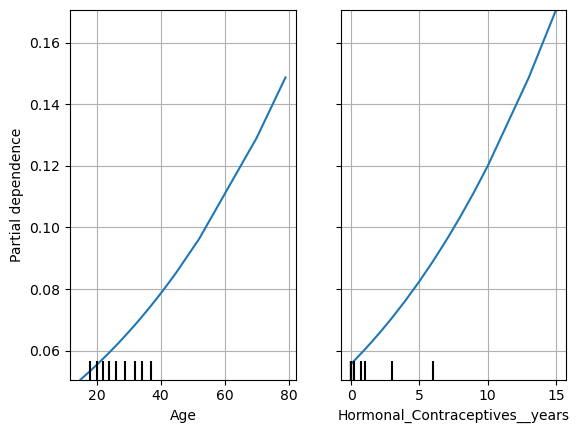

In [23]:
from sklearn.linear_model import LogisticRegression

pdp_plot(LogisticRegression(max_iter=1000), X_train, y_train, X_val=X_val, features=["Age", "Hormonal_Contraceptives__years"])

/var/folders/34/q4vcf0710b9cm75lplc7sx2w0000gn/T/ipykernel_15700/3313765008.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  m.fit(X_train, y_train)


R2-score:  0.9970845481049563


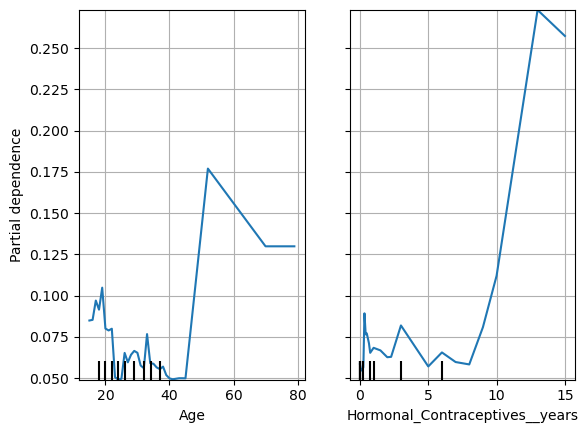

In [24]:
from sklearn.ensemble import RandomForestClassifier
pdp_plot(RandomForestClassifier(), X_train, y_train, X_val=X_val, features=["Age", "Hormonal_Contraceptives__years"])

/var/folders/34/q4vcf0710b9cm75lplc7sx2w0000gn/T/ipykernel_15700/3313765008.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  m.fit(X_train, y_train)


R2-score:  0.9970845481049563


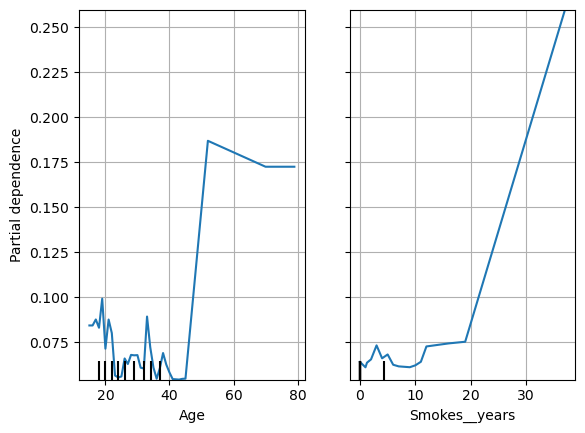

In [25]:
pdp_plot(RandomForestClassifier(), X_train, y_train, X_val=X_val, features=["Age", "Smokes__years"])

In [26]:
X_val['Age'].describe()

count    172.000000
mean      27.581395
std        9.071471
min       15.000000
25%       21.000000
50%       26.000000
75%       33.000000
max       79.000000
Name: Age, dtype: float64

In [27]:
X_val['Age'][X_val['Age']>50]

3      52.0
682    70.0
667    79.0
Name: Age, dtype: float64

/var/folders/34/q4vcf0710b9cm75lplc7sx2w0000gn/T/ipykernel_15700/3313765008.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  m.fit(X_train, y_train)


R2-score:  0.9970845481049563


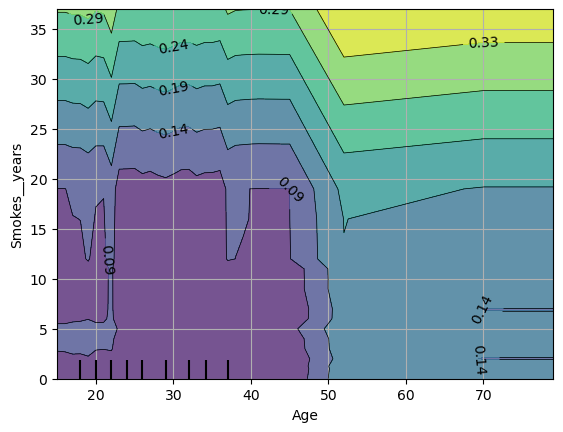

In [28]:
pdp_plot(RandomForestClassifier(), X_train, y_train, X_val=X_val, features=[["Age", "Smokes__years"]])

Q: Does this plot imply that smoking increases the cancer probability regardless of age? Take a close look at the upper-left corner

## Individual conditional expectation (ICE) <- local

In [29]:
from sklearn.inspection import PartialDependenceDisplay

def ice_plot(M, X_train, y_train, features, X_val=None, kind="individual"):
    if X_val is None:
        X_val = X_train

    m = M
    m.fit(X_train, y_train)
    print("R2-score: ", m.score(X_train, y_train))

    pdp = PartialDependenceDisplay.from_estimator(
        m,
        X_val,
        features,
        kind=kind, grid_resolution=100, percentiles=(0,1),
        pd_line_kw=dict(color="red")
    )

    for ax in pdp.axes_[0,:]:
        ax.grid(True)

/var/folders/34/q4vcf0710b9cm75lplc7sx2w0000gn/T/ipykernel_15700/3963527484.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  m.fit(X_train, y_train)


R2-score:  0.9970845481049563


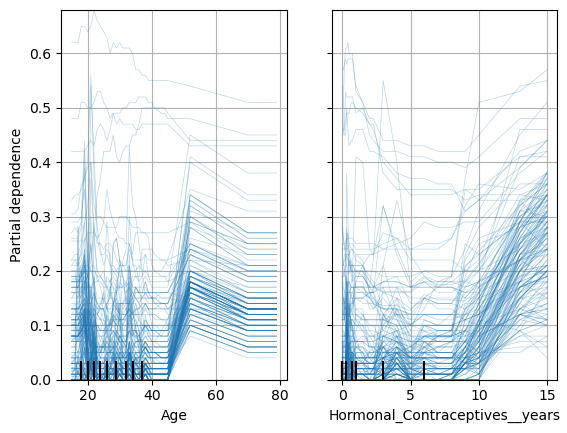

In [30]:
ice_plot(RandomForestClassifier(random_state=1), X_train, y_train, X_val=X_val, features=["Age", "Hormonal_Contraceptives__years"])

/var/folders/34/q4vcf0710b9cm75lplc7sx2w0000gn/T/ipykernel_15700/3963527484.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  m.fit(X_train, y_train)


R2-score:  0.9970845481049563


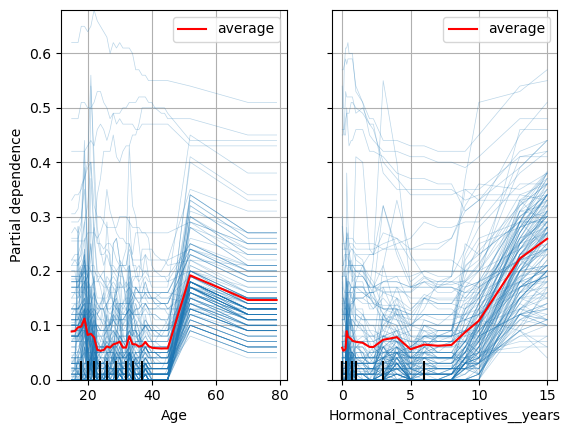

In [31]:
ice_plot(RandomForestClassifier(random_state=1), X_train, y_train, X_val=X_val, features=["Age", "Hormonal_Contraceptives__years"], kind="both")

### Exercise 3.3

Use a `RandomForestClassifier(random_state=1)`.
What is the predicted cancer probability with an Age of sixty years according to the datapoint with the highest predicted cancer probability of the validation dataset?
Write a function that returns that value.

In [4]:
cancer_path = "datasets/cervical_cancer/risk_factors_cervical_cancer_pre.csv"
cancer_data = FeatureModel(cancer_path)
cancer_data.add_target("Biopsy")
cancer_data.add_all_features_but_target()
X_train, y_train, X_val, y_val = cancer_data.return_Xy(train_test_split=True)

FeatureModel(->Not fully specified yet!)
FeatureModel(Biopsy ~ -1 + Age + Number_of_sexual_partners + First_sexual_intercourse + Num_of_pregnancies + Smokes + Smokes__years + Hormonal_Contraceptives + Hormonal_Contraceptives__years + IUD + IUD__years + STDs + STDs__Number_of_diagnosis + STDs__Time_since_first_diagnosis + STDs__Time_since_last_diagnosis )


In [32]:
from sklearn.ensemble import RandomForestClassifier

def ex_3_3() -> float:

    def get_ICE(model, X_val, feature, value):
        X_val_new = X_val.copy()
        X_val_new[feature] = value
        prediction = model.predict_proba(X_val_new)[:, 1]
        ICE = prediction
        return ICE

    model = RandomForestClassifier(random_state=1)
    model.fit(X_train, y_train)

    return get_ICE(model, X_val, "Age", 60).max()

In [33]:
ex_3_3()

/var/folders/34/q4vcf0710b9cm75lplc7sx2w0000gn/T/ipykernel_15700/1823038447.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


0.52

In [34]:
compare("ex_3_3", ex_3_3)

Great work!


/var/folders/34/q4vcf0710b9cm75lplc7sx2w0000gn/T/ipykernel_15700/1823038447.py:13: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


## Accumulated local effects (ALE)

In [35]:
from PyALE import ale # <- This really is more of an m-plot

In [36]:
from sklearn.ensemble import RandomForestRegressor

X,y = bike_data.return_Xy()
regr = RandomForestRegressor(random_state=1)
regr.fit(X,y)

/var/folders/34/q4vcf0710b9cm75lplc7sx2w0000gn/T/ipykernel_15700/3858323213.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  regr.fit(X,y)


RandomForestRegressor(random_state=1)

/Users/gimchangheon/opt/anaconda3/envs/xML/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/gimchangheon/opt/anaconda3/envs/xML/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/gimchangheon/opt/anaconda3/envs/xML/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/gimchangheon/opt/anaconda3/envs/xML/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/gimchangheon/opt/anaconda3/envs/xML/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names

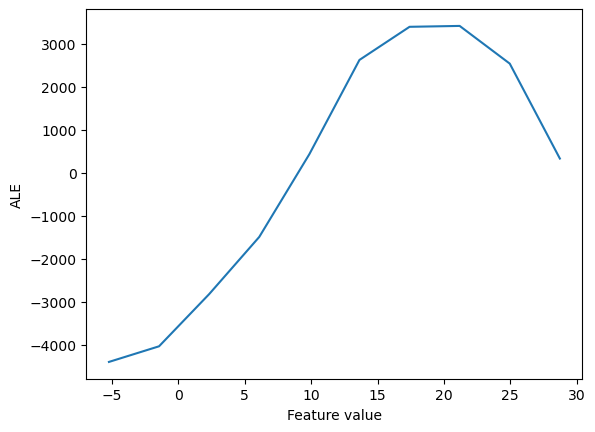

In [37]:
import numpy as np
from scipy.integrate import cumtrapz
import pandas as pd

def ALE(regr, feature_idx, X, bins=40):
    # Check if X is a pandas DataFrame
    if isinstance(X, pd.DataFrame):
        X = X.values

    # 1. Divide feature into intervals
    X_sorted = np.sort(X[:, feature_idx])
    feature_min = X_sorted[0]
    feature_max = X_sorted[-1]
    intervals = np.linspace(feature_min, feature_max, bins+1)

    ale_values = []

    # 2. For each interval, and for each datapoint in a interval, calculate the prediction difference dy 
    # by replacing x1 with the interval lower and upper limit
    for i in range(bins):
        lower = intervals[i]
        upper = intervals[i + 1]
        mask = (X[:, feature_idx] >= lower) & (X[:, feature_idx] < upper)

        if not np.any(mask):
            ale_values.append(0)
            continue

        X_lower = X[mask].copy()
        X_upper = X[mask].copy()
        X_lower[:, feature_idx] = lower
        X_upper[:, feature_idx] = upper

        dy = regr.predict(X_upper) - regr.predict(X_lower)

        # 3. For each interval average prediction differences dy(s)
        avg_dy = np.mean(dy)

        # 4. Integrate average prediction differences
        ale_values.append(avg_dy)

    # 5. Center integrated average prediction differences
    ale_values = cumtrapz(ale_values, intervals[:-1], initial=0)
    ale_values -= np.mean(ale_values)

    return intervals, ale_values

feature_idx = X.columns.get_loc("temp") # specify the index of the feature for which you want to compute the ALE
grid_size = 10
intervals, ale_values = ALE(regr, feature_idx, X, bins=grid_size)

import matplotlib.pyplot as plt

plt.plot(intervals[:-1], ale_values)
plt.xlabel('Feature value')
plt.ylabel('ALE')
plt.show()


PyALE._ALE_generic:INFO: Continuous feature detected.


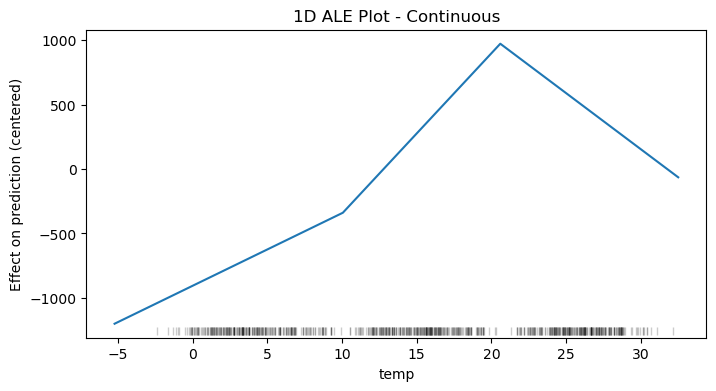

In [38]:
ale_eff = ale(X, regr, ["temp"], grid_size=3, include_CI=False,)

In [39]:
ale_eff

,eff,size
temp,,
-5.220871,-1200.381206,0.0
10.055849,-338.901575,244.0
20.591651,972.902278,244.0
32.498349,-63.894759,243.0


PyALE._ALE_generic:INFO: Continuous feature detected.


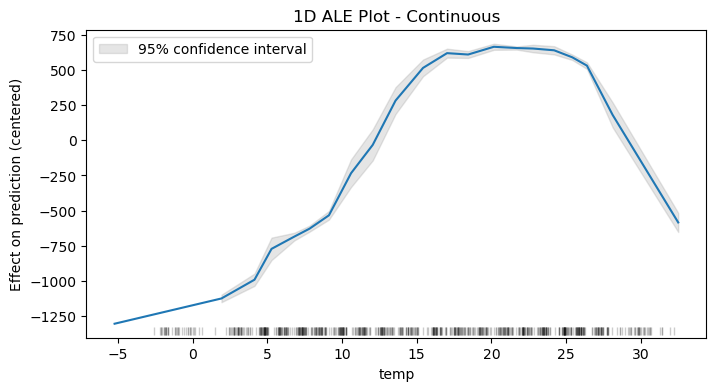

In [40]:
ale_eff = ale(X, regr, ["temp"], grid_size=20, include_CI=True, C=0.95)

In [41]:
ale_eff.reset_index()

,temp,eff,size,lowerCI_95%,upperCI_95%
0,-5.220871,-1304.437601,0.0,NaN,NaN
1,1.931288,-1124.719223,37.0,-1151.469293,-1097.969152
2,4.141651,-991.390612,36.0,-1035.050161,-947.731062
3,5.282623,-771.891422,37.0,-851.772184,-692.010661
4,6.805000,-684.808922,36.0,-712.302558,-657.315286
5,7.823349,-628.386760,37.0,-649.767757,-607.005763
6,9.124356,-533.140371,36.0,-563.883810,-502.396933
7,10.604151,-233.696858,37.0,-332.230836,-135.162880
8,12.053349,-32.454636,36.0,-143.061396,78.152125
9,13.580849,282.745635,37.0,187.392936,378.098333


### Exercise 3.4

For what *lower* temperature is the expectation of the centered effect on the predicted number of rented bikes exactly zero?
(You may use the table directly above)

In [42]:
from sklearn.linear_model import LinearRegression

def ex_3_4() -> float:
    ale_table= ale_eff.reset_index()

    # Find the indices where the effect changes sign
    sign_change_indices = ale_table[ale_table['eff'] >= 0].index
    index_1= sign_change_indices[0] -1
    index_2= sign_change_indices[1] -1

    # Get the corresponding temperatures and effects
    temp_1 = ale_table ['temp'][index_1]
    temp_2= ale_table ['temp'][index_2]
    effect_1= ale_table ['eff'][index_1]
    effect_2= ale_table ['eff'][index_2]

    # Fit a linear regression model to the two temperature points
    X= [[effect_1], [effect_2]]
    y = [temp_1, temp_2]
    model = LinearRegression()
    model.fit(X,y)

    # Predict the temperature for an ALE effect of 0.0
    prediction = model.predict ([[0.0]])

    return prediction [0]

In [32]:
ex_3_4()

12.210628229981651

In [43]:
compare("ex_3_4", ex_3_4)

Great work!


### Exercise 3.5 (harder)

Using the above table, what is the 95%-confidence interval of the effect delta when going from `temp=1.931288` to `temp=4.141651`?

*Hint 1*: The 95%-confidence intervall for a normal distribution is at $1.96$ standard deviations

*Hint 2*: https://en.wikipedia.org/wiki/Sum_of_normally_distributed_random_variables

In [44]:
ale_table= ale_eff.reset_index()
ale_table



,temp,eff,size,lowerCI_95%,upperCI_95%
0,-5.220871,-1304.437601,0.0,NaN,NaN
1,1.931288,-1124.719223,37.0,-1151.469293,-1097.969152
2,4.141651,-991.390612,36.0,-1035.050161,-947.731062
3,5.282623,-771.891422,37.0,-851.772184,-692.010661
4,6.805000,-684.808922,36.0,-712.302558,-657.315286
5,7.823349,-628.386760,37.0,-649.767757,-607.005763
6,9.124356,-533.140371,36.0,-563.883810,-502.396933
7,10.604151,-233.696858,37.0,-332.230836,-135.162880
8,12.053349,-32.454636,36.0,-143.061396,78.152125
9,13.580849,282.745635,37.0,187.392936,378.098333


In [49]:
def ex_3_5() -> (float, float):
    M_x = ale_table['eff'][1]
    M_y = ale_table['eff'][2]

    sigma_x = (ale_table['upperCI_95%'][1] - ale_table['lowerCI_95%'][1]) / (2*1.96)
    sigma_y = (ale_table['upperCI_95%'][2] - ale_table['lowerCI_95%'][2]) / (2*1.96)

    M_z = M_y - M_x
    simga_z = np.sqrt(sigma_x**2 + sigma_y**2)

    r1 = M_z - 1.96*simga_z
    r2 = M_z + 1.96*simga_z
    return r1, r2


In [50]:
ex_3_5()

(82.12585169913822, 184.5313705230839)

In [51]:
compare("ex_3_5", ex_3_5)

Great work!


## Permutation feature importance

Features that are deemed of low importance for a bad model (low cross-validation score) could be very important for a good model. Therefore it is always important to evaluate the predictive power of a model using a held-out set (or better with cross-validation) prior to computing importances. Permutation importance does not reflect to the intrinsic predictive value of a feature by itself but *how important this feature is for a particular model*.


In [52]:
from sklearn.inspection import permutation_importance

In [53]:
X_train, y_train, X_val, y_val = bike_data.return_Xy(train_test_split=True)

In [54]:
from sklearn.ensemble import GradientBoostingRegressor
regr = GradientBoostingRegressor(random_state=1)
regr.fit(X_train, y_train)
regr.score(X_val, y_val)

/Users/gimchangheon/opt/anaconda3/envs/xML/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.9021025738192169

In [55]:
r = permutation_importance(regr, X_val, y_val, n_repeats=20, random_state=1)

In [56]:
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{X_val.columns[i]:<22} | "
              f"{r.importances_mean[i]:.3f}"
              f" +/- {r.importances_std[i]:.3f}")

days_since_01_01_2011  | 0.711 +/- 0.047
temp                   | 0.459 +/- 0.034
hum                    | 0.050 +/- 0.010
windspeed              | 0.030 +/- 0.009
weathersit             | 0.016 +/- 0.007
season                 | 0.011 +/- 0.004
mnth                   | 0.008 +/- 0.003
workingday             | 0.007 +/- 0.002


### Exercise 3.6

Using a `GradientBoostingClassifier(random_state=1)` and `permutation_importance(..., n_repeats=20, random_state=1)`. What is the most important feature of in the cervical cancer dataset?
Write a function that returns this column name.

In [57]:
cancer_path = "datasets/cervical_cancer/risk_factors_cervical_cancer_pre.csv"
cancer_data = FeatureModel(cancer_path)
cancer_data.add_target("Biopsy")
cancer_data.add_all_features_but_target()
X_train, y_train, X_val, y_val = cancer_data.return_Xy(train_test_split=True)

FeatureModel(->Not fully specified yet!)
FeatureModel(Biopsy ~ -1 + Age + Number_of_sexual_partners + First_sexual_intercourse + Num_of_pregnancies + Smokes + Smokes__years + Hormonal_Contraceptives + Hormonal_Contraceptives__years + IUD + IUD__years + STDs + STDs__Number_of_diagnosis + STDs__Time_since_first_diagnosis + STDs__Time_since_last_diagnosis )


In [60]:
from sklearn.inspection import permutation_importance
from sklearn.ensemble import GradientBoostingClassifier

def most_important_feature():
    # Fit the model
    clif = GradientBoostingClassifier(random_state=1)
    clif.fit(X_train, y_train)

    # Calculate permutation importances
    r = permutation_importance(clif, X_val, y_val, n_repeats=20, random_state=1)
    importances_mean, importances_std, importances = r.importances_mean, r.importances_std, r.importances

    # Find the most important feature
    most_important_idx = r.importances_mean.argmax()
    most_important_feature = X_val.columns[most_important_idx]

    return most_important_feature


In [61]:
most_important_feature()

/Users/gimchangheon/opt/anaconda3/envs/xML/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


'First_sexual_intercourse'

In [62]:
def ex_3_6() -> str:
    return most_important_feature()


In [63]:
ex_3_6()

/Users/gimchangheon/opt/anaconda3/envs/xML/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


'First_sexual_intercourse'

In [64]:
compare("ex_3_6", ex_3_6)

/Users/gimchangheon/opt/anaconda3/envs/xML/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Great work!


Q: Argue why you might question this result?

Q: Repeat `ex_3_6` with a `RandomForestClassifier` instead. What is now the result?

In [65]:
from ce3_compare import scores

In [66]:
scores

{'ex_3_1': True,
 'ex_3_2': True,
 'ex_3_3': True,
 'ex_3_4': True,
 'ex_3_5': True,
 'ex_3_6': True}

In [67]:
write_submission_txt()

In [68]:
grade("ce3_Changhun_Kim.txt")

'100.0% are correct'